In [1]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
add_noise = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.7),
])
pitch_shift = Compose([
    PitchShift(min_semitones=-4, max_semitones=12, p=0.5),
])

<class 'numpy.ndarray'>


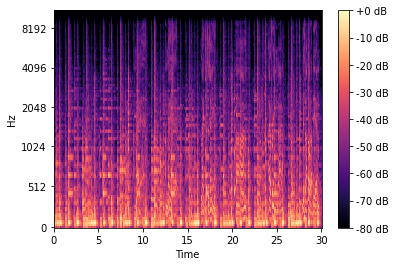

In [3]:
import librosa.display

#setting melspec features
n_mels = 128
hop_length = 1024
n_fft = 1024
sr = 22050

sample = "Data/genres_original/blues/blues.00003.wav"
sample, sr = librosa.load(sample)
print(type(sample))
#extract melspec features using librosa
S = librosa.feature.melspectrogram(sample, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

#convert it to DB scale
S_DB = librosa.power_to_db(S, ref=np.max)

#display the spectrogram
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB')

In [4]:
#temporary list for the input data
data = []

#list to append all the labels
Y = []

base_path = 'Data/genres_original'

#looping through all label directories
for label in tqdm(os.listdir(base_path)):
    file_path = base_path + '/' + label
    
    #looping through each file in the directory
    for pth in os.listdir(file_path):
        
        try:
            final_path = file_path + '/' + pth

            #loading original file
            audio, sr = librosa.load(final_path,duration = 28)
            
            #appending data to a list
            data.append(audio)
          

            #appending labels to the label list
            Y.append(label)
            
        except:
            print("Error in file", pth)
            pass
        
#converting list to a numpy array
X = np.stack(data)

 50%|█████     | 5/10 [00:05<00:05,  1.13s/it]

Error in file jazz.00054.wav


100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


In [5]:
from sklearn.model_selection import train_test_split
#split the data using the SkLearn library
audio_train, audio_test, y_train, y_test = train_test_split( X, Y, test_size=0.20, random_state=6)

In [6]:
def get_melspec(audio, sr = sr, n_fft = n_fft, hop_length = hop_length, n_mels = n_mels):
    #calculate the melspectogram of the provided audio wave
    S = librosa.feature.melspectrogram(audio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    return S

In [7]:
#temporary list for the input data
X_train = []

#list to append all the labels
Y_train = []

#looping through train data to create melspec and augment data
for i, dat in tqdm(enumerate(audio_train)):
        
    try:

        #adding noise to the file
        noisy_audio = add_noise(dat ,sr)
        #changing pitch of the audio
        pitch_audio = pitch_shift(dat, sr)

        #generate melspec for original and augmented files
        mel = get_melspec(dat)
        noise_mel = get_melspec(noisy_audio)
        pitch_mel = get_melspec(pitch_audio)

        #appending augmented data to original training data
        X_train.append(mel)
        Y_train.append(y_train[i])
        X_train.append(noise_mel)
        Y_train.append(y_train[i])
        X_train.append(pitch_mel)
        Y_train.append(y_train[i])


    except Exception as e:
        print("Error in file:", pth)
        print("Error:", e)

799it [06:18,  2.11it/s]


In [8]:
#temporary list for the input data
X_test = []

#list to append all the labels
Y_test = []

#looping through train data to create melspec and augment data
for i, dat in tqdm(enumerate(audio_test)):
        
    try:
        #generate melspec for original and augmented files
        mel = get_melspec(dat)
       
        #Appending test melspec to list
        X_test.append(mel)
        Y_test.append(y_test[i])
        

    except Exception as e:
        print("Error in file:", pth)
        print("Error:", e)

200it [00:03, 58.24it/s]


In [9]:
#converting the test and train data to numpy array
X_train = np.stack(X_train)
X_test = np.stack(X_test)

In [10]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y_train)

Y_train = encoder.transform(Y_train).reshape([len(Y_train), 1])

encoder = LabelEncoder()
encoder.fit(Y_test)

Y_test = encoder.transform(Y_test).reshape([len(Y_test), 1])

In [11]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [12]:
#importing the keras modules
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, GRU
from keras.callbacks import Callback, EarlyStopping

#Initiating the model as Sequential
model = Sequential()

#Adding the CNN layers along with some drop outs and maxpooling
model.add(Conv2D(64, 2, activation = 'relu', input_shape = (X_train.shape[1:])))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(128, 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.1))
model.add(Conv2D(512, 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4,4)))
model.add(Dropout(0.1))
model.add(Conv2D(512, 2, activation = 'relu'))
model.add(MaxPooling2D(pool_size = (4,4)))
model.add(Dropout(0.1))

#flattening the data to be passed to a dense layer
model.add(Flatten())

#Adding the dense layers
model.add(Dense(2048, activation = 'relu'))
model.add(Dense(1024, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))

#final output layer with 10 predictions to be made
model.add(Dense(10, activation = 'softmax'))

'''
Optimizer = Adam
Loss = Sparse Categorical CrossEntropy
'''
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 602, 64)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 301, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 301, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 300, 128)      32896     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 150, 128)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 150, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 149, 512)      2

In [13]:
history = model.fit(X_train, Y_train,batch_size= 8, validation_data=(X_test, Y_test),epochs=50)

Epoch 1/50
300/300 [==============================] - 28s 49ms/step - loss: 2.8894 - accuracy: 0.2069 - val_loss: 1.8843 - val_accuracy: 0.2850
Epoch 2/50
300/300 [==============================] - 13s 43ms/step - loss: 1.8388 - accuracy: 0.3187 - val_loss: 1.7447 - val_accuracy: 0.3400
Epoch 3/50
300/300 [==============================] - 12s 41ms/step - loss: 1.6989 - accuracy: 0.3696 - val_loss: 1.7639 - val_accuracy: 0.3150
Epoch 4/50
300/300 [==============================] - 12s 41ms/step - loss: 1.5515 - accuracy: 0.4343 - val_loss: 1.4897 - val_accuracy: 0.4600
Epoch 5/50
300/300 [==============================] - 12s 40ms/step - loss: 1.4248 - accuracy: 0.4914 - val_loss: 1.6219 - val_accuracy: 0.4350
Epoch 6/50
300/300 [==============================] - 12s 41ms/step - loss: 1.2740 - accuracy: 0.5448 - val_loss: 1.5459 - val_accuracy: 0.4550
Epoch 7/50
300/300 [==============================] - 12s 41ms/step - loss: 1.0337 - accuracy: 0.6462 - val_loss: 1.8239 - val_accuracy:

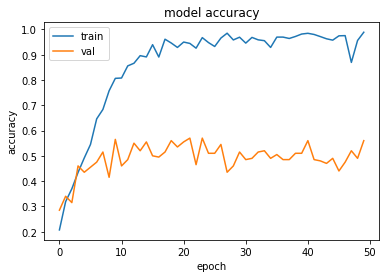

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# import tensorflow as tf 
# x1 = tf.keras.layers.Dense(8)(np.arange(10).reshape(5, 2))
# print(x1.shape, x1)
# x2 = tf.keras.layers.Dense(8)(np.arange(10, 20).reshape(5, 2))
# print(x2.shape, x2)
# concatted = tf.keras.layers.Concatenate()([x1, x2])
# print(concatted.shape, concatted)